In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data.dataset import Dataset
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import torchvision.utils as vutils
import random
import os
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### Loading Data

In [ ]:
data_dir = "./hw2_data/face/train"
img_list = os.listdir(data_dir)
for i in img_list:
    loc = os.path.join(data_dir, i)
    img = image.imread(loc)
    print(img.shape)
    print(len(img_list))
    break

class faceData(Dataset):
    def __init__(self, dir, transform):
        imgs = []
        img_list = os.listdir(dir)
        img_list.sort()
        for i in img_list:
            loc = os.path.join(dir, i)
            img = image.imread(loc)
            imgs.append(img)
        self.data =  np.array(imgs)
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.data[index]
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.data)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = faceData(data_dir, transform)
print(len(dataset))
train_dl = DataLoader(dataset, 100, shuffle = True, num_workers=2)



(64, 64, 3)
40000


### Initialization

In [125]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [126]:
# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

device = "cuda" if torch.cuda.is_available() else "cpu"

### GAN

In [127]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
#         print(x.shape)
        return x

In [128]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            PrintLayer(),
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 100, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            PrintLayer(), # Add Print layer for debug
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            PrintLayer(), # Add Print layer for debug
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            PrintLayer(), # Add Print layer for debug
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            PrintLayer(), # Add Print layer for debug
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [74]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            PrintLayer(),
            # input is (nc) x 64 x 64
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            PrintLayer(), # Add Print layer for debug
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            PrintLayer(), # Add Print layer for debug
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            PrintLayer(), # Add Print layer for debug
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            PrintLayer(), # Add Print layer for debug
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [129]:
generator = Generator().to(device)
generator.apply(weights_init)
# print(generator)
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
# print(discriminator)

Discriminator(
  (main): Sequential(
    (0): PrintLayer()
    (1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): PrintLayer()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): PrintLayer()
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): PrintLayer()
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2, inplace=True)
    (15): PrintLayer()
    (16): Con

In [130]:
fixed_noise = torch.randn(64, 100, 1, 1)
loss = nn.BCELoss()
real_label = 1.
fake_label = 0.
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

In [120]:
from torch.utils.tensorboard import SummaryWriter
writer_g = SummaryWriter('runs/generator')
writer_d = SummaryWriter('runs/discriminator')
# dataiter = iter(train_dl)
# images = dataiter.next()
images_test = np.ones((10, 3, 64, 64), np.double)
# print(images_test.shape)
images_test = torch.from_numpy(images_test)
discriminator = discriminator.double()
writer_d.add_graph(discriminator,images_test)
writer_d.close()
writer_g.add_graph(generator, torch.Tensor(np.random.rand(10, 100, 1, 1).astype(np.double)))
writer_g.close()
# change it to double

In [131]:
test = next(iter(train_dl))
print(test.shape)

torch.Size([100, 3, 64, 64])


### Training GAN

In [133]:
def training(generator, discriminator, dataloader):
    for i, data in enumerate(dataloader, 0):
        discriminator.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_cpu).view(-1)
        errD_real = loss(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        ## Train with all-fake batch
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = loss(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

         ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = loss(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (t, epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
#         if  ((t == epochs-1) and (i == len(dataloader)-1)):
#             with torch.no_grad():
#                 fake = generator(fixed_noise).detach().to(device)
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        
img_list = []
G_losses = []
D_losses = []
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    training(generator, discriminator, train_dl)
    

Epoch 1
-------------------------------
[0/30][0/400]	Loss_D: 1.3599	Loss_G: 15.3202	D(x): 0.5451	D(G(z)): 0.0000 / 0.0000
[0/30][50/400]	Loss_D: 1.0099	Loss_G: 10.1533	D(x): 0.9655	D(G(z)): 0.5307 / 0.0001
[0/30][100/400]	Loss_D: 0.4489	Loss_G: 3.9083	D(x): 0.7603	D(G(z)): 0.0578 / 0.0296
[0/30][150/400]	Loss_D: 0.3281	Loss_G: 4.3300	D(x): 0.8508	D(G(z)): 0.0939 / 0.0243
[0/30][200/400]	Loss_D: 0.7132	Loss_G: 6.0202	D(x): 0.8032	D(G(z)): 0.2934 / 0.0047
[0/30][250/400]	Loss_D: 0.7115	Loss_G: 6.7540	D(x): 0.8670	D(G(z)): 0.3499 / 0.0038
[0/30][300/400]	Loss_D: 0.5433	Loss_G: 5.5970	D(x): 0.8284	D(G(z)): 0.1899 / 0.0095
[0/30][350/400]	Loss_D: 0.7179	Loss_G: 6.6162	D(x): 0.9452	D(G(z)): 0.4194 / 0.0042
Epoch 2
-------------------------------
[1/30][0/400]	Loss_D: 0.5943	Loss_G: 6.3141	D(x): 0.8922	D(G(z)): 0.2902 / 0.0045
[1/30][50/400]	Loss_D: 0.6915	Loss_G: 5.5317	D(x): 0.7572	D(G(z)): 0.1960 / 0.0105
[1/30][100/400]	Loss_D: 0.9332	Loss_G: 7.8731	D(x): 0.9487	D(G(z)): 0.4776 / 0.0010


[11/30][250/400]	Loss_D: 1.7803	Loss_G: 0.5889	D(x): 0.2513	D(G(z)): 0.0182 / 0.6082
[11/30][300/400]	Loss_D: 0.4261	Loss_G: 2.8012	D(x): 0.8122	D(G(z)): 0.1624 / 0.0785
[11/30][350/400]	Loss_D: 0.4874	Loss_G: 2.1258	D(x): 0.7776	D(G(z)): 0.1851 / 0.1531
Epoch 13
-------------------------------
[12/30][0/400]	Loss_D: 0.6640	Loss_G: 1.9502	D(x): 0.6758	D(G(z)): 0.1731 / 0.1788
[12/30][50/400]	Loss_D: 0.4836	Loss_G: 1.9005	D(x): 0.7295	D(G(z)): 0.1174 / 0.1813
[12/30][100/400]	Loss_D: 0.5349	Loss_G: 2.0218	D(x): 0.7239	D(G(z)): 0.1377 / 0.1653
[12/30][150/400]	Loss_D: 0.7580	Loss_G: 1.3302	D(x): 0.5510	D(G(z)): 0.0723 / 0.3114
[12/30][200/400]	Loss_D: 0.5719	Loss_G: 2.3580	D(x): 0.7300	D(G(z)): 0.1872 / 0.1220
[12/30][250/400]	Loss_D: 0.5917	Loss_G: 2.6597	D(x): 0.8083	D(G(z)): 0.2773 / 0.0894
[12/30][300/400]	Loss_D: 0.8329	Loss_G: 2.0575	D(x): 0.6549	D(G(z)): 0.2620 / 0.1626
[12/30][350/400]	Loss_D: 0.5059	Loss_G: 2.4152	D(x): 0.8328	D(G(z)): 0.2511 / 0.1101
Epoch 14
------------------

[23/30][0/400]	Loss_D: 0.6570	Loss_G: 4.1877	D(x): 0.9589	D(G(z)): 0.4005 / 0.0242
[23/30][50/400]	Loss_D: 0.4772	Loss_G: 3.5478	D(x): 0.8688	D(G(z)): 0.2521 / 0.0402
[23/30][100/400]	Loss_D: 0.2690	Loss_G: 5.0627	D(x): 0.9482	D(G(z)): 0.1750 / 0.0096
[23/30][150/400]	Loss_D: 0.3443	Loss_G: 2.9772	D(x): 0.9082	D(G(z)): 0.2001 / 0.0681
[23/30][200/400]	Loss_D: 0.3563	Loss_G: 3.2479	D(x): 0.9322	D(G(z)): 0.2254 / 0.0521
[23/30][250/400]	Loss_D: 0.5782	Loss_G: 3.3576	D(x): 0.8078	D(G(z)): 0.2623 / 0.0471
[23/30][300/400]	Loss_D: 0.4537	Loss_G: 3.0208	D(x): 0.9061	D(G(z)): 0.2587 / 0.0669
[23/30][350/400]	Loss_D: 0.4394	Loss_G: 2.4373	D(x): 0.7652	D(G(z)): 0.1123 / 0.1095
Epoch 25
-------------------------------
[24/30][0/400]	Loss_D: 0.3880	Loss_G: 2.9198	D(x): 0.8046	D(G(z)): 0.1241 / 0.0725
[24/30][50/400]	Loss_D: 0.3457	Loss_G: 2.4563	D(x): 0.8607	D(G(z)): 0.1511 / 0.1100
[24/30][100/400]	Loss_D: 0.3751	Loss_G: 3.7681	D(x): 0.9557	D(G(z)): 0.2451 / 0.0325
[24/30][150/400]	Loss_D: 1.589

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
torch.Size([3, 64, 64])


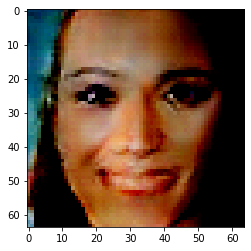

In [134]:
input_t = torch.Tensor(np.random.rand(10, 100, 1, 1).astype(np.double)).cuda()
x = generator(input_t).cpu()
print(type(x))
print(x[0].shape)
def display_img(img):
    img = img.detach().numpy()
    img = torch.from_numpy(img)
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(x[0])

In [ ]:
# save model
torch.save(generator.state_dict(), "./check_point/hw2gan_gen_checkpoint.pth")
torch.save(discriminator.state_dict(), "./check_point/hw2gan_dis_checkpoint.pth")